In [1]:
from qiskit.quantum_info import Pauli, Operator, DensityMatrix, Statevector
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
import numpy as np

IPSTATE = Statevector([1/np.sqrt(2), 1j*1/np.sqrt(2)])
IMSTATE = Statevector([1/np.sqrt(2), -1j*1/np.sqrt(2)])
_qc_ = QuantumCircuit(2, name='Bell Op')
_qc_.h(0)
_qc_.cnot(0, 1)
BELL_OP = Operator(_qc_)

In [22]:
qa = QuantumRegister(1, name='alice')
qb = QuantumRegister(2, name='bob')
qc = QuantumRegister(1, name='chalie')
cr = ClassicalRegister(4)
qc = QuantumCircuit(qa, qb, qc, cr)
qc.h(0)
qc.cx(0, 1)
qc.h(2)
qc.cx(2, 3)
state = DensityMatrix(qc)

In [35]:
state.expectation_value(Pauli('Y'), qargs=(3,))

0.0

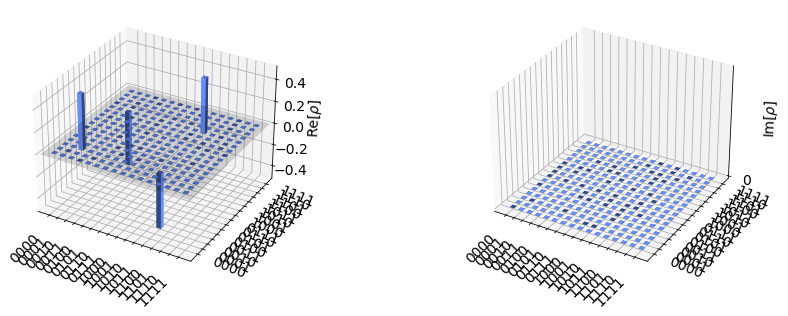

In [9]:


from qiskit.visualization import plot_state_city
plot_state_city(state.measure((1, 2))[1])

In [15]:
DensityMatrix.from_label('r')

DensityMatrix([[0.5+0.j , 0. -0.5j],
               [0. +0.5j, 0.5+0.j ]],
              dims=(2,))


In [36]:
# make state
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
bell_meas_op = Operator(qc).adjoint()
phi_p = DensityMatrix.from_instruction(qc)

(0.7071067811865474+0j)

In [50]:
state = phi_p.tensor(phi_p)
state = state.evolve(bell_meas_op, qargs=(1, 2))
result, state = state.measure((1, 2))
print(state.expectation_value(1/2*(Operator(Pauli('I'))+Operator(Pauli('X'))), qargs=(0,)))

(0.5000000000000001+0j)


In [146]:
from itertools import product

PAULI_OPS = [Operator(Pauli('I')), Operator(Pauli('X')), Operator(Pauli('Y')), Operator(Pauli('Z'))]
I, X, Y, Z = PAULI_OPS
PHI_P = 1/np.sqrt(2)*(Statevector.from_label('00')+Statevector.from_label('11'))
PHI_M = 1/np.sqrt(2)*(Statevector.from_label('00')-Statevector.from_label('11'))
PSI_P = 1/np.sqrt(2)*(Statevector.from_label('10')+Statevector.from_label('01'))
PSI_M = 1/np.sqrt(2)*(Statevector.from_label('10')-Statevector.from_label('01'))



def A(x):
    if x==0:
        O=Z
    if x==1:
        O=X
    if x==2:
        O=Y
    return O

def C(z):
    if z==0:
        D = Z+X
    if z==1:
        D = Z-X
    if z==2:
        D = Z+Y
    if z==3:
        D = Z-Y
    if z==4:
        D = X+Y
    if z==5:
        D = X-Y
    D = 1/np.sqrt(2)*D
    return D

def B(b):
    if b=='00':
        return Operator(PHI_P)
    if b=='01':
        return Operator(PHI_M)
    if b=='10':
        return Operator(PSI_P)
    if b=='11':
        return Operator(PSI_M)

def CHSH3Opeator(initial_state:DensityMatrix=None):
    S = {}
    for x in range(3):
        for z in range(6):
            for b in ('00', '01', '10', '11'):
                value = []
                for a, c in product(range(2), repeat=2):
                    measA = A(x)[a]
                    measB = B(b)
                    measC = C(z)[c]
                    meas = measA.tensor(measB).tensor(measC)
                    value.append(initial_state.expectation_value(meas))
                S[(x, z, b)] = sum(value)
    return S

state = DensityMatrix(PHI_P).tensor(DensityMatrix(PHI_P))
#S = CHSH3Opeator(state)

def CHSHOperator(initial_state:DensityMatrix=None, xvals=None, zvals=None, opt3=None):
    values = []
    for x in xvals:
        for z in zvals:
            if opt3 is None:
                values.append(initial_state.expectation_value(A(x).tensor(C(z)), qargs=(0, 1)))
            else:
                values.append(initial_state.expectation_value(A(x).tensor(C(z)).tensor(opt3), qargs=(0, 1, 2, 3)))
    print(values)
    return sum(np.array([1, 1, 1, -1])*np.array(values))

state = DensityMatrix(PHI_P)
print(CHSHOperator(state, zvals=(0, 1), xvals=(0, 1)))
state = DensityMatrix(PHI_M)
print(CHSHOperator(state, zvals=(2, 3), xvals=(0, 2)))
state = DensityMatrix(PSI_P)
print(CHSHOperator(state, zvals=(4, 5), xvals=(1, 2)))

def CHSH3Operator(initial_state:DensityMatrix=None):
    state = initial_state.evolve(bell_meas_op, qargs=(2, 3))
    b, state = state.measure((2, 3))
    S = {}
    for x in range(3):
        for z in range(6):
            S[(x, z)] = state.expectation_value(A(x).tensor(C(z)), qargs=(0, 1))
            print(S[(x, z)])
    Jb = (-1)**int(b[1])*(S[(0, 0)]+S[(0, 1)])
    Jb+= (-1)**int(b[0])*(S[(1, 0)]-S[(1, 1)])
    Jb+= (-1)**int(b[1])*(S[(0, 2)]+S[(0, 3)])
    Jb-= (-1)**(int(b[1])+int(b[0]))*(S[(2, 2)]+S[(2, 3)])
    Jb+= (-1)**int(b[0])*(S[(1, 4)]+S[(1, 5)])
    Jb-= (-1)**(int(b[1])+int(b[0]))*(S[(2, 4)]+S[(2, 5)])
    return b, Jb

qc = QuantumCircuit(4)
qc.h(0)
qc.h(1)
qc.cx(0, 2)
qc.cx(1, 3)
state = DensityMatrix.from_instruction(qc)
CHSH3Operator(state)


    

[(0.7071067811865474+0j), (0.7071067811865474+0j), (0.7071067811865474+0j), (-0.7071067811865474+0j)]
(2.8284271247461894+0j)
[(0.7071067811865474+0j), (0.7071067811865474+0j), (0.7071067811865474+0j), (-0.7071067811865474+0j)]
(2.8284271247461894+0j)
[(0.7071067811865474+0j), (0.7071067811865474+0j), (0.7071067811865474+0j), (-0.7071067811865474+0j)]
(2.8284271247461894+0j)
(-0.7071067811865475+0j)
(-0.7071067811865475+0j)
(-0.7071067811865475+0j)
(-0.7071067811865475+0j)
0j
0j
(0.7071067811865475+0j)
(-0.7071067811865475+0j)
0j
0j
(0.7071067811865475+0j)
(0.7071067811865475+0j)
0j
0j
(0.7071067811865475+0j)
(-0.7071067811865475+0j)
(0.7071067811865475+0j)
(-0.7071067811865475+0j)


('10', (-5.65685424949238+0j))

In [182]:
from itertools import product

PAULI_OPS = [Operator(Pauli('I')), Operator(Pauli('X')), Operator(Pauli('Y')), Operator(Pauli('Z'))]
I, X, Y, Z = PAULI_OPS
PHI_P = 1/np.sqrt(2)*(Statevector.from_label('00')+Statevector.from_label('11'))
PHI_M = 1/np.sqrt(2)*(Statevector.from_label('00')-Statevector.from_label('11'))
PSI_P = 1/np.sqrt(2)*(Statevector.from_label('10')+Statevector.from_label('01'))
PSI_M = 1/np.sqrt(2)*(Statevector.from_label('10')-Statevector.from_label('01'))


def A(x):
    if x==0:
        O=Z
    if x==1:
        O=X
    if x==2:
        O=Y
    return O

def C(z):
    if z==0:
        D = Z+X
    if z==1:
        D = Z-X
    if z==2:
        D = Z+Y
    if z==3:
        D = Z-Y
    if z==4:
        D = X+Y
    if z==5:
        D = X-Y
    D = 1/np.sqrt(2)*D
    return D

def CHSHOperator(initial_state:DensityMatrix=None, xvals=None, zvals=None, weight=[1, 1, 1, -1]):
    values = []
    for x in xvals:
        for z in zvals:
            values.append(initial_state.expectation_value(A(x).tensor(C(z)), qargs=(0, 1)))
    return sum(np.array(weight)*np.array(values))

state = DensityMatrix(PHI_P)
print(CHSHOperator(state, zvals=(0, 1), xvals=(0, 1)))
state = DensityMatrix(PHI_M)
print(CHSHOperator(state, zvals=(2, 3), xvals=(0, 2)))
state = DensityMatrix(PSI_P)
print(CHSHOperator(state, zvals=(4, 5), xvals=(1, 2)))

def CHSH3Operator(initial_state:DensityMatrix=None):
    state = initial_state.evolve(bell_meas_op, qargs=(2, 3))
    b, state = state.measure((2, 3))
    ret = 0
    ret += CHSHOperator(state, xvals=(0, 1), zvals=(0, 1), weight=[(-1)**int(b[0]), (-1)**int(b[0]), (-1)**int(b[1]), -(-1)**int(b[1])])
    ret += CHSHOperator(state, xvals=(0, 2), zvals=(2, 3), weight=[(-1)**int(b[0]), (-1)**int(b[0]), -(-1)**(int(b[1])+int(b[0])), (-1)**(int(b[1])+int(b[0]))])
    ret += CHSHOperator(state, xvals=(1, 2), zvals=(4, 5), weight=[(-1)**int(b[1]), (-1)**int(b[1]), -(-1)**(int(b[1])+int(b[0])), (-1)**(int(b[1])+int(b[0]))])
    return b, ret

qc = QuantumCircuit(4)
qc.h(0)
qc.h(1)
qc.cx(0, 2)
qc.cx(1, 3)
state = DensityMatrix.from_instruction(qc)
CHSH3Operator(state)


(2.8284271247461894+0j)
(2.8284271247461894+0j)
(2.8284271247461894+0j)


('01', (8.48528137423857+0j))